<a href="https://colab.research.google.com/github/PradeepThapa/100-Days-Of-ML-Code/blob/master/Task_8_1_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# install requirements
!pip install gym
!apt-get update
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!apt-get install xvfb
!pip install pyvirtualdisplay
!pip -q install pyglet
!pip -q install pyopengl

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [53]:
# BOX2D Let you use the bipedal agent and environment
# Pybullet is you key to physical simulations and a good alternative to MOJOCO which can cost you

!apt-get install swig
!pip install box2d box2d-kengz
!pip install pybullet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 60 not upgraded.


In [54]:
import gym
env = gym.make("BipedalWalker-v3")

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [55]:
# imports
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple
import Box2D

In [56]:
# Set seed for experiment reproducibility
seed = 4233
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [57]:
# ===========================
#   Replay Buffer
# credit
'''
https://gym.openai.com/evaluations/eval_IU3wehAQQRuJRbzMjy26QQ/
'''
# ===========================
class ReplayBuffer(object):
    def __init__(self, buffer_size, random_seed=None):
        """
        The right side of the deque contains the most recent experiences
        The buffer stores a number of past experiences to stochastically sample from
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque(maxlen=self.buffer_size)
        self.seed = random_seed
        if self.seed is not None:
            random.seed(self.seed)

    def add(self, state, action, reward, t, s2):
        experience = (state, action, reward, t, s2)
        self.buffer.append(experience)
        self.count += 1

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch]).reshape(batch_size, -1)
        t_batch = np.array([_[3] for _ in batch]).reshape(batch_size, -1)
        s2_batch = np.array([_[4] for _ in batch])
        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

In [58]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [59]:
num_actions = env.action_space.shape[0]  # 2
num_hidden_units = 256

model = ActorCritic(num_actions, num_hidden_units)

In [60]:
# step function of open ai to tensorflow
def env_step(action):
  """Returns state, reward and done flag given an action."""


  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action):
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [61]:
# run episode to collect training data
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> List[tf.Tensor]:

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)

    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)

    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])

    # Apply action to the environment to get next state and reward
    action = env.action_space.sample()
    state, reward, done = tf_env_step(action)
    print(reward)
    state.set_shape(initial_state_shape)

     # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards

In [62]:
"""Compute expected returns per timestep."""
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

In [63]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

# compute loss
def compute_loss(
    action_probs,  
    values,  
    returns) -> tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

In [64]:
optimizer = tf.keras.optimizers.Adam(learning_rate=10) #learning rate is according to author's suggestion

# calculate gradient and estimate the gradient

@tf.function
def train_step(
    initial_state,
    model, 
    optimizer, 
    gamma, 
    max_steps_per_episode):

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(initial_state, model, max_steps_per_episode) 
    print(rewards)

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

In [65]:
min_episodes_criterion = 100
max_episodes = 2000
max_steps_per_episode = 100

# considered solved if average reward is >= 300 over 100 
# consecutive trials
reward_threshold = 300
running_reward = -500

# Discount factor for future rewards
gamma = 0.995

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)
cumreward = []

for i in range(max_episodes):
  initial_state = tf.constant(env.reset(), dtype=tf.float32)
  episode_reward = int(train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))
  #print(episode_reward)
  
  episodes_reward.append(episode_reward)
  running_reward = statistics.mean(episodes_reward)
  cumreward.append((i, running_reward))

  # Show average episode reward every 10 episodes
  if i % 10 == 0:
    pass #print(f'Episode {i}: average reward: {avg_reward}')

  if running_reward > reward_threshold:  
      break
  elif i >= min_episodes_criterion:
    break
    

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Tensor("while/PyFunc:1", dtype=int32, device=/job:localhost/replica:0/task:0)
Tensor("TensorArrayV2Stack_2/TensorListStack:0", dtype=int32)
Tensor("while/PyFunc:1", dtype=int32, device=/job:localhost/replica:0/task:0)
Tensor("TensorArrayV2Stack_2/TensorListStack:0", dtype=int32)

Solved at episode 100: average reward: -2.00!


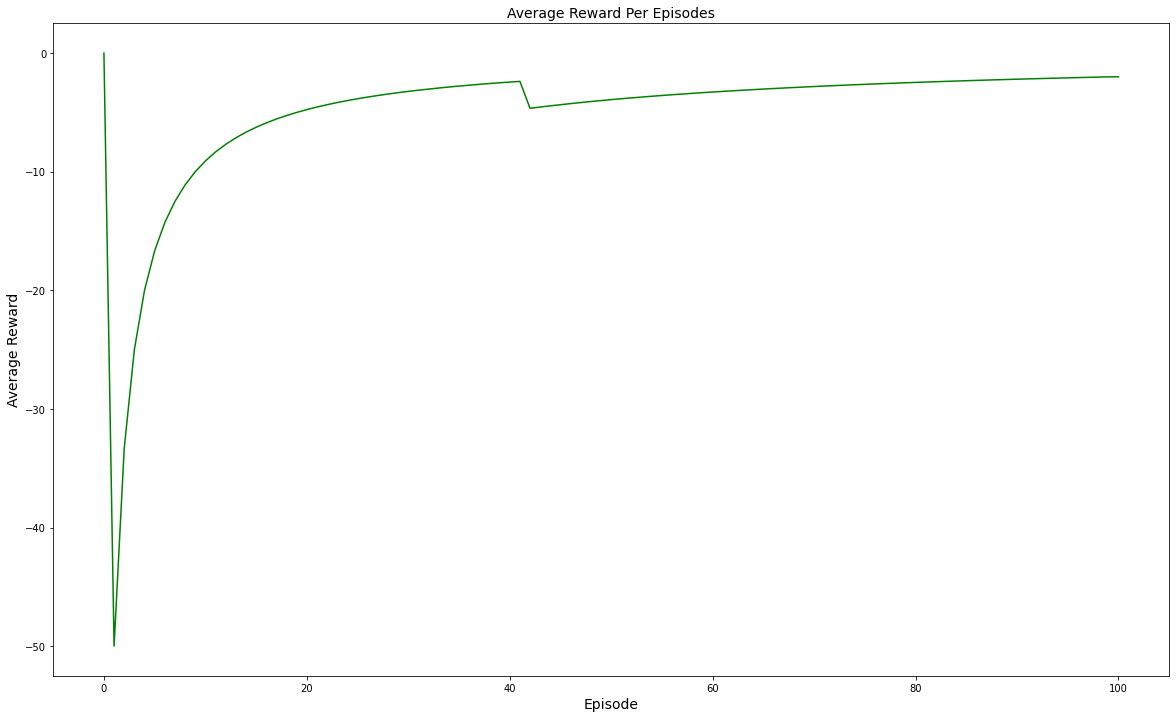

In [66]:
import matplotlib.pyplot as plt

# plot cummulative reward per episodes
Rx = [x for x, y in cumreward]
Ry = [y for x, y in cumreward]
'''Ry = np.cumsum(Ry)
Ry = Ry.tolist()'''

plt.figure(figsize=(20, 12))
plt.plot(Rx, Ry,color='green')
plt.title('Average Reward Per Episodes', fontsize=14)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)
plt.grid(False)
plt.show()

# Pendulum enviroment

In [67]:
import gym
import tensorflow as tf
env = gym.make('Pendulum-v0')

Tensor("while/PyFunc:1", dtype=int32, device=/job:localhost/replica:0/task:0)
Tensor("TensorArrayV2Stack_2/TensorListStack:0", dtype=int32)
Tensor("while/PyFunc:1", dtype=int32, device=/job:localhost/replica:0/task:0)
Tensor("TensorArrayV2Stack_2/TensorListStack:0", dtype=int32)

Solved at episode 100: average reward: -618.48!


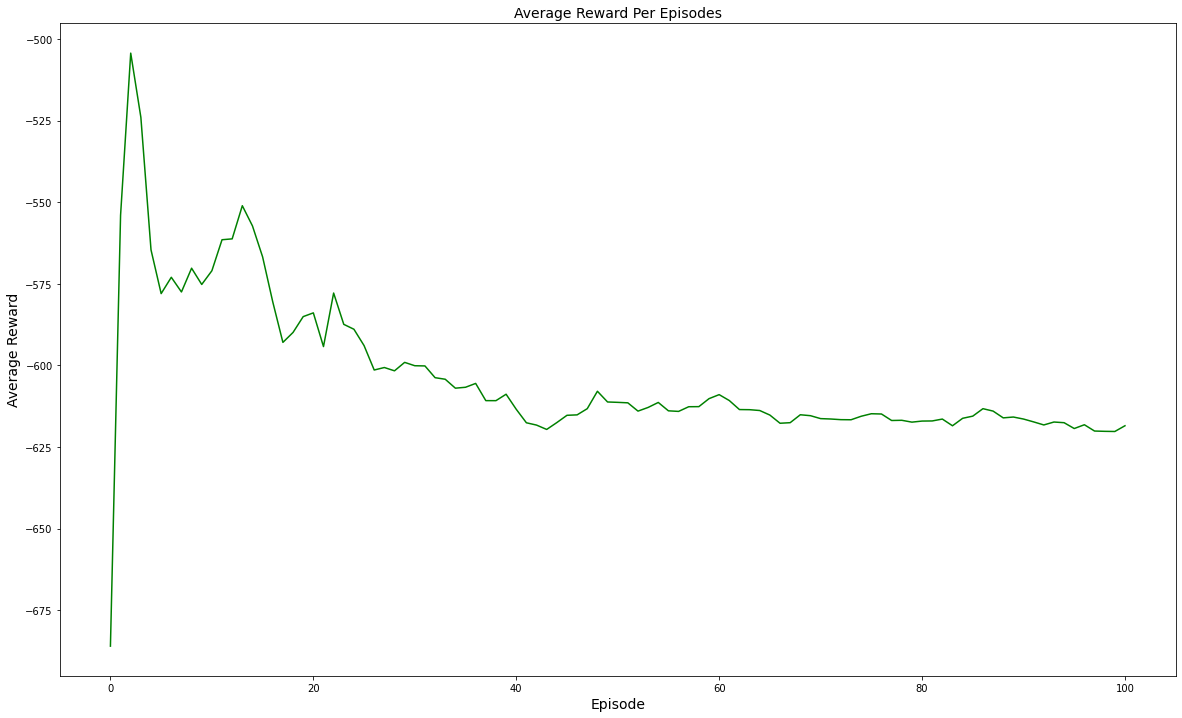

In [68]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)


num_actions = env.action_space.shape[0]  # 2
num_hidden_units = 256

model = ActorCritic(num_actions, num_hidden_units)


# Wrap OpenAI Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action):
  """Returns state, reward and done flag given an action."""


  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action):
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])
  

def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> List[tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state
  actions = []

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)

    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)

    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])

    # Apply action to the environment to get next state and reward
    action = env.action_space.sample()
    state, reward, done = tf_env_step(action)
    print(reward)
    state.set_shape(initial_state_shape)

     # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards


def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs,  
    values,  
    returns) -> tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss


optimizer = tf.keras.optimizers.Adam(learning_rate=10)


# calculate gradient and estimate the gradient

@tf.function
def train_step(
    initial_state,
    model, 
    optimizer, 
    gamma, 
    max_steps_per_episode):

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(initial_state, model, max_steps_per_episode) 
    print(rewards)

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward


min_episodes_criterion = 100
max_episodes = 2000
max_steps_per_episode = 100

# pendulum problem is solved when it is up
# consecutive trials
reward_threshold = 100
running_reward = 0

# Discount factor for future rewards
gamma = 0.995

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)
cumreward = []

for i in range(max_episodes):
  initial_state = tf.constant(env.reset(), dtype=tf.float32)
  episode_reward = int(train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))
  #print(episode_reward)
  
  episodes_reward.append(episode_reward)
  running_reward = statistics.mean(episodes_reward)
  #print(running_reward)
  cumreward.append((i, running_reward))

  # Show average episode reward every 10 episodes
  if i % 10 == 0:
    pass #print(f'Episode {i}: average reward: {avg_reward}')

  if running_reward > reward_threshold:  
      break
  elif i >= min_episodes_criterion:
    break
    

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

import matplotlib.pyplot as plt

# plot cummulative reward per episodes
Rx = [x for x, y in cumreward]
Ry = [y for x, y in cumreward]
'''Ry = np.cumsum(Ry)
Ry = Ry.tolist()'''

plt.figure(figsize=(20, 12))
plt.plot(Rx, Ry,color='green')
plt.title('Average Reward Per Episodes', fontsize=14)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)
plt.grid(False)
plt.show()